In [1]:
import pickle
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np

In [2]:
def add_nodes_from_user_data(G, user_data):
    """
    Add nodes to the graph from user data, including attributes.

    Parameters:
    - G (networkx.Graph): The graph to add nodes to.
    - user_data (pandas.DataFrame): The user data containing the 'Id' column and other attributes.

    Returns:
    None
    """
    for _, row in user_data.iterrows():
        node_attributes = row.to_dict()
        user_id = node_attributes.pop('Id')  # Remove the 'Id' as it will be the node identifier
        G.add_node(user_id, **node_attributes)
        
def add_edges_from_post_data(G, posts_data):
    """
    Add edges to the graph based on post data.

    Parameters:
    - G (networkx.Graph): The graph to add edges to.
    - posts_data (pandas.DataFrame): The post data containing information about posts.

    Returns:
    None
    """
    # Filter to only answers and drop NaNs
    answers_data = posts_data[posts_data['PostTypeId'] == 2].dropna(subset=['ParentId', 'OwnerUserId'])

    # Create a lookup table for question askers
    question_askers = posts_data[posts_data['PostTypeId'] == 1].set_index('Id')['OwnerUserId']

    # Iterate through answers
    for answerer_id, question_id in zip(answers_data['OwnerUserId'], answers_data['ParentId']):
        asker_id = question_askers.get(question_id)
        # Check that answerer and asker are not the same
        if asker_id is not None and answerer_id != asker_id:
            G.add_edge(answerer_id, asker_id)

def add_edges_from_comment_data(G, comments_data, posts_data):
    """
    Adds edges to the graph `G` based on the comment data.

    Parameters:
        G (networkx.Graph): The graph to which the edges will be added.
        comments_data (pandas.DataFrame): The comment data containing 'UserId' and 'PostId' columns.
        posts_data (pandas.DataFrame): The post data containing 'Id' and 'OwnerUserId' columns.

    Returns:
        None
    """
    # Drop NaNs
    comments_data = comments_data.dropna(subset=['PostId', 'UserId'])

    # Create a lookup table for post owners
    post_owners = posts_data.set_index('Id')['OwnerUserId']

    # Iterate through comments
    for commenter_id, post_id in zip(comments_data['UserId'], comments_data['PostId']):
        post_owner_id = post_owners.get(post_id)
        # Check that commenter and post owner are not the same
        if post_owner_id is not None and commenter_id != post_owner_id:
            G.add_edge(commenter_id, post_owner_id)

def preprocess_user_data(user_data, posts_data, comments_data, threshold):
    """
    Preprocesses user data by calculating the number of posts and comments per user,
    combining the counts, and filtering out users who do not meet the threshold.
    
    Args:
        user_data (DataFrame): DataFrame containing user data.
        posts_data (DataFrame): DataFrame containing posts data.
        comments_data (DataFrame): DataFrame containing comments data.
        threshold (int): Minimum count threshold for users to be considered active.
    
    Returns:
        DataFrame: DataFrame containing only the data of active users.
    """
    # Calculate the number of posts per user
    posts_count = posts_data['OwnerUserId'].value_counts()
    
    # Calculate the number of comments per user
    comments_count = comments_data['UserId'].value_counts()
    
    # Combine the counts, filling in zeros for users who haven't posted or commented
    combined_count = posts_count.add(comments_count, fill_value=0)
    
    # Filter users who meet the threshold
    active_users = combined_count[combined_count >= threshold].index
    
    # Filter the user_data DataFrame to include only active users
    active_user_data = user_data[user_data['Id'].isin(active_users)]
    
    return active_user_data

def preprocess_post_data(posts_data, active_user_data):
    """
    Preprocesses the post data by filtering it to only include posts owned by active users.

    Parameters:
    posts_data (DataFrame): The dataframe containing all the post data.
    active_user_data (DataFrame): The dataframe containing the data of active users.

    Returns:
    DataFrame: The filtered dataframe containing only the posts owned by active users.
    """
    active_posts_data = posts_data[posts_data['OwnerUserId'].isin(active_user_data['Id'])]
    
    return active_posts_data

def preprocess_comment_data(comments_data, active_user_data, active_posts_data):
    """
    Preprocesses comment data by filtering it to only include comments owned by active users
    and comments on posts by active users.

    Parameters:
    comments_data (DataFrame): The original comment data.
    active_user_data (DataFrame): The data of active users.
    active_posts_data (DataFrame): The data of active posts.

    Returns:
    DataFrame: The preprocessed comment data.
    """
    # Filter comments to only those owned by active users
    active_comments_data = comments_data[comments_data['UserId'].isin(active_user_data['Id'])]
    
    # Filter comments to only those on posts by active users
    active_comments_data = active_comments_data[active_comments_data['PostId'].isin(active_posts_data['Id'])]
    
    return active_comments_data

def convert_timestamps_to_strings(G):
    """
    Converts timestamps in the graph G to strings.

    Parameters:
    - G (networkx.Graph): The graph to convert timestamps in.

    Returns:
    - None
    """
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                # Convert Timestamp to string
                G.nodes[node][key] = value.strftime('%Y-%m-%d %H:%M:%S')

    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                # Convert Timestamp to string
                G.edges[u, v][key] = value.strftime('%Y-%m-%d %H:%M:%S')

In [3]:
# Create the network
G = nx.DiGraph()

# Load user data
with open('../data/raw/active_users_with_sentiment.pkl', 'rb') as file:
    user_data = pickle.load(file)

# Print user data columns
print('User data columns:', user_data.columns)

User data columns: Index(['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'Views',
       'UpVotes', 'DownVotes', 'PostCount', 'CommentCount',
       'AcceptedAnswerCount', 'AnswerCount', 'TotalActivity', 'AvgAnswerScore',
       'AvgPostScore', 'AcceptedAnswerFraction', 'AnswerSentiment'],
      dtype='object')


In [4]:
# Add edges from post (questions and answers) interactions
with open('../data/raw/posts_typecasted_1.pkl', 'rb') as file:
    posts_data_1 = pickle.load(file)
with open('../data/raw/posts_typecasted_2.pkl', 'rb') as file:
    posts_data_2 = pickle.load(file)
with open('../data/raw/posts_typecasted_3.pkl', 'rb') as file:
    posts_data_3 = pickle.load(file)
with open('../data/raw/posts_typecasted_4.pkl', 'rb') as file:
    posts_data_4 = pickle.load(file)

# Combine all post data
posts_data = pd.concat([posts_data_1, posts_data_2, posts_data_3, posts_data_4], ignore_index=True)

# Print post data columns
print('Post data columns:', posts_data.columns)

Post data columns: Index(['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount'],
      dtype='object')


In [5]:
# Add edges from comment interactions
with open('../data/raw/comments_typecasted_1.pkl', 'rb') as file:
    comments_data_1 = pickle.load(file)
with open('../data/raw/comments_typecasted_2.pkl', 'rb') as file:
    comments_data_2 = pickle.load(file)
with open('../data/raw/comments_typecasted_3.pkl', 'rb') as file:
    comments_data_3 = pickle.load(file)
with open('../data/raw/comments_typecasted_4.pkl', 'rb') as file:
    comments_data_4 = pickle.load(file)
with open('../data/raw/comments_typecasted_5.pkl', 'rb') as file:
    comments_data_5 = pickle.load(file)

# Combine all comment data
comments_data = pd.concat([comments_data_1, comments_data_2, comments_data_3, comments_data_4, comments_data_5], ignore_index=True)

# Print comment data columns
print('Comment data columns:', comments_data.columns)

Comment data columns: Index(['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId'], dtype='object')


In [6]:
# Add nodes to the graph
add_nodes_from_user_data(G, user_data)

# Print number of nodes
print('Number of nodes:', len(G.nodes()))

Number of nodes: 11810


In [7]:
# Preprocess posts data to only include posts from users in the network
posts_data = preprocess_post_data(posts_data, user_data)

In [ ]:
# Add edges to the graph
add_edges_from_post_data(G, posts_data)
# Print number of edges
print('Number of edges:', len(G.edges()))

Number of edges: 2718


In [ ]:
# Preprocess comments data to only include comments from users in the network
comments_data = preprocess_comment_data(comments_data, user_data, posts_data)

In [ ]:
# Add edges to the graph
add_edges_from_comment_data(G, comments_data, posts_data)
# Print number of edges
print('Number of edges:', len(G.edges()))

Number of edges: 12150


In [ ]:
# Convert all Timestamps to strings
convert_timestamps_to_strings(G)
# Save the network
nx.write_gexf(G, '../data/processed/network/network.gexf')

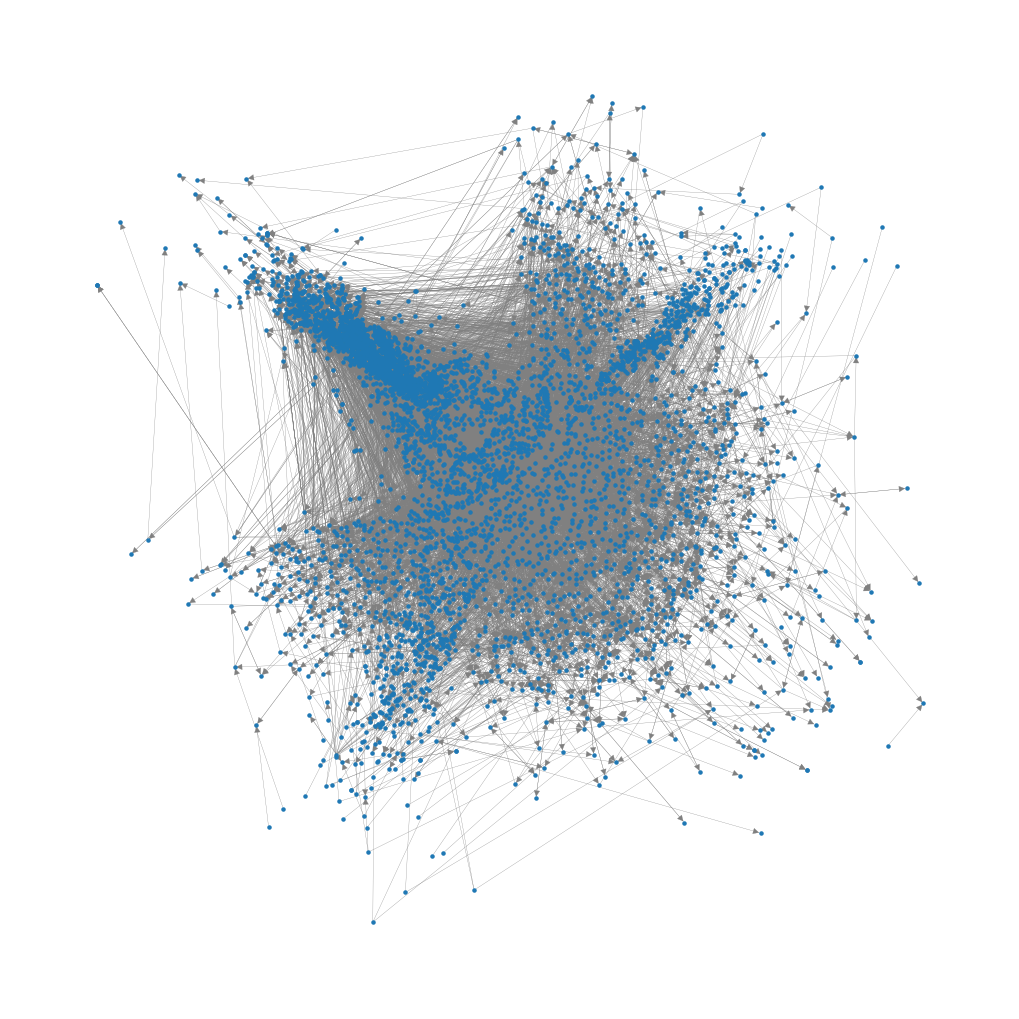

In [ ]:
# Visualize Network

# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# Generate a layout for the subgraph
pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(subgraph, k=0.1, iterations=20)

# Draw the nodes and the edges (tune the size and opacity to make the graph readable)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)

# Hide the axis
plt.axis('off')
# Show the plot
plt.show()

In [ ]:
# Degree distribution histogram

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

# Print degree distribution with the format: degree, count
print("Degree, Count")
for d in np.unique(degree_sequence):
    print(f"Degree: {d}, Count: {degree_sequence.count(d)}")

Degree, Count
Degree: 0, Count: 5951
Degree: 1, Count: 2217
Degree: 2, Count: 1224
Degree: 3, Count: 751
Degree: 4, Count: 479
Degree: 5, Count: 308
Degree: 6, Count: 188
Degree: 7, Count: 143
Degree: 8, Count: 89
Degree: 9, Count: 58
Degree: 10, Count: 56
Degree: 11, Count: 45
Degree: 12, Count: 28
Degree: 13, Count: 27
Degree: 14, Count: 25
Degree: 15, Count: 25
Degree: 16, Count: 20
Degree: 17, Count: 12
Degree: 18, Count: 18
Degree: 19, Count: 8
Degree: 20, Count: 11
Degree: 21, Count: 10
Degree: 22, Count: 5
Degree: 23, Count: 6
Degree: 24, Count: 6
Degree: 25, Count: 6
Degree: 26, Count: 3
Degree: 27, Count: 3
Degree: 28, Count: 8
Degree: 29, Count: 2
Degree: 30, Count: 3
Degree: 31, Count: 2
Degree: 32, Count: 2
Degree: 33, Count: 2
Degree: 34, Count: 2
Degree: 35, Count: 5
Degree: 36, Count: 3
Degree: 37, Count: 1
Degree: 38, Count: 3
Degree: 39, Count: 2
Degree: 40, Count: 1
Degree: 41, Count: 2
Degree: 42, Count: 1
Degree: 44, Count: 3
Degree: 46, Count: 2
Degree: 48, Count: 

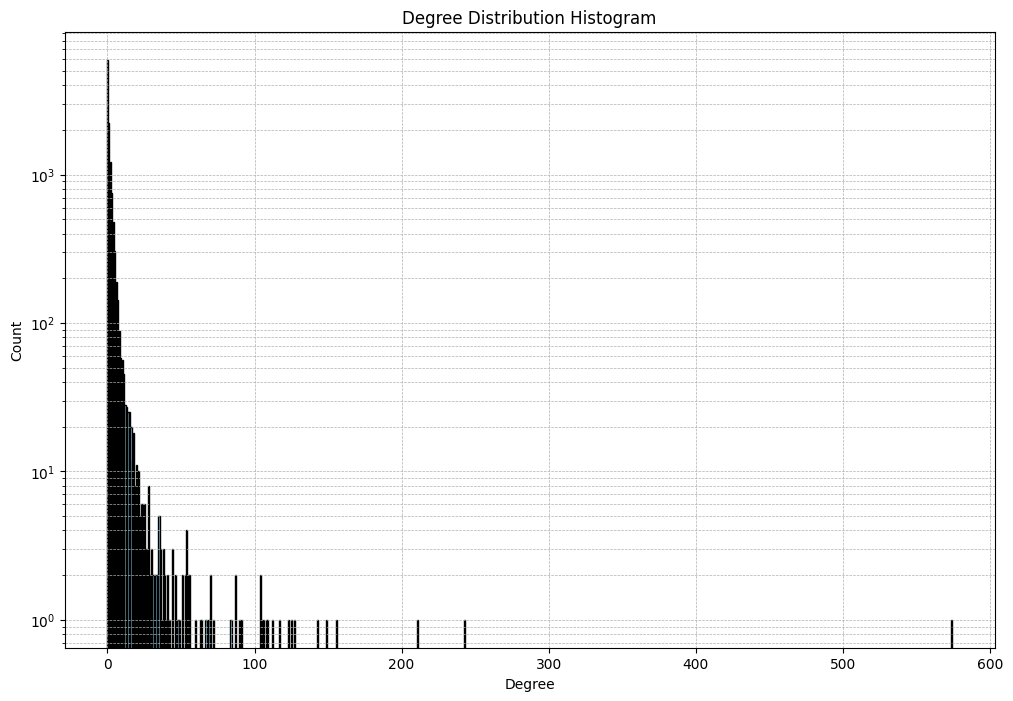

In [ ]:
# Degree distribution data
degrees = np.unique(degree_sequence)
counts = [degree_sequence.count(d) for d in degrees]

# Plotting the degree distribution as a bar plot
plt.figure(figsize=(12, 8))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='black')

# Since you have a wide range of degrees, you might want to use a log scale
plt.yscale('log')

# Adding labels and title
plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show the plot
plt.show()

In [ ]:
# List of nodes with the highest degree along with their answer sentiment with format: node, degree, sentiment
print("Nodes with the highest degree and their sentiment:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]:
    sentiment = G.nodes[node]['AnswerSentiment']  # Access the 'AnswerSentiment' attribute
    print(f"{node}: {degree} connections, Answer Sentiment: {sentiment}")

Nodes with the highest degree and their sentiment:
104349: 574 connections, Answer Sentiment: 0.11898799641122387
2988730: 243 connections, Answer Sentiment: 0.1297822678017351
642070: 211 connections, Answer Sentiment: 0.1170151371983046
2823755: 156 connections, Answer Sentiment: 0.11771248466211429
16343464: 149 connections, Answer Sentiment: 0.1081640902244537
51685: 143 connections, Answer Sentiment: 0.13892525102275013
126214: 127 connections, Answer Sentiment: 0.09954384137156978
1453822: 125 connections, Answer Sentiment: 0.11601505305529707
166749: 123 connections, Answer Sentiment: 0.11280988728531394
2390182: 117 connections, Answer Sentiment: 0.12958072712892643


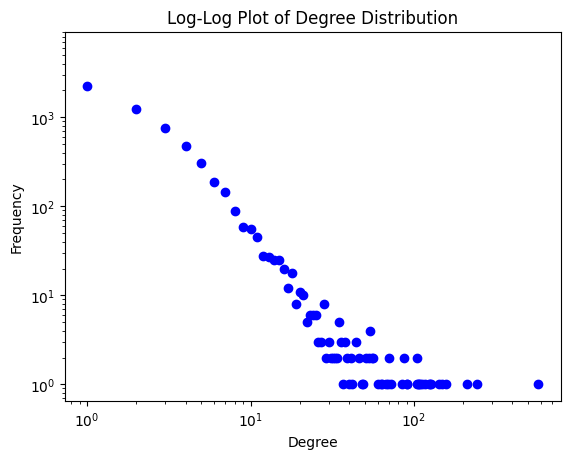

In [ ]:
# Log-Log plot

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.plot(deg, cnt, 'bo')
plt.title("Log-Log Plot of Degree Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

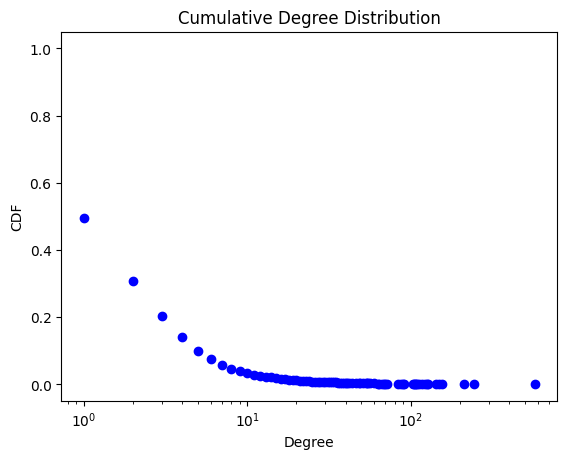

In [ ]:
# Cumulative degree distribution

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

cnt_array = np.array(cnt, dtype=float)
cdf = np.cumsum(cnt_array) / sum(cnt_array)

fig, ax = plt.subplots()
plt.plot(deg, cdf, 'bo')
plt.title("Cumulative Degree Distribution")
plt.ylabel("CDF")
plt.xlabel("Degree")
ax.set_xscale('log')
# ax.set_yscale('log') # Optional: Log scale for the y-axis
plt.show()


In [ ]:
# Degree Centrality

centrality = nx.degree_centrality(G)
# Sort nodes by degree centrality
central_nodes = sorted(centrality, key=centrality.get, reverse=True)

In [ ]:
# Print the 30 nodes with highest degree centrality along with their answer sentiment with format: node, degree centrality, sentiment
print("Nodes with the highest degree centrality and their sentiment:")
count = 1
for node in central_nodes[:30]:
    sentiment = G.nodes[node]['AnswerSentiment']  # Access the 'AnswerSentiment' attribute
    print(f"{count} {node}: {centrality[node]:.4f}, Answer Sentiment: {sentiment:.4f}")
    count += 1

Nodes with the highest degree centrality and their sentiment:
1 104349: 0.0486, Answer Sentiment: 0.1190
2 2988730: 0.0206, Answer Sentiment: 0.1298
3 642070: 0.0179, Answer Sentiment: 0.1170
4 2823755: 0.0132, Answer Sentiment: 0.1177
5 16343464: 0.0126, Answer Sentiment: 0.1082
6 51685: 0.0121, Answer Sentiment: 0.1389
7 126214: 0.0108, Answer Sentiment: 0.0995
8 1453822: 0.0106, Answer Sentiment: 0.1160
9 166749: 0.0104, Answer Sentiment: 0.1128
10 2390182: 0.0099, Answer Sentiment: 0.1296
11 1322401: 0.0095, Answer Sentiment: 0.1451
12 6622587: 0.0092, Answer Sentiment: 0.1806
13 893: 0.0091, Answer Sentiment: 0.1273
14 6045800: 0.0090, Answer Sentiment: 0.1133
15 4492932: 0.0089, Answer Sentiment: 0.0982
16 84270: 0.0088, Answer Sentiment: 0.1259
17 651174: 0.0088, Answer Sentiment: 0.0690
18 699305: 0.0077, Answer Sentiment: 0.1418
19 5741205: 0.0076, Answer Sentiment: 0.1955
20 4333359: 0.0074, Answer Sentiment: 0.2041
21 987358: 0.0074, Answer Sentiment: 0.0862
22 3767239: 0.00

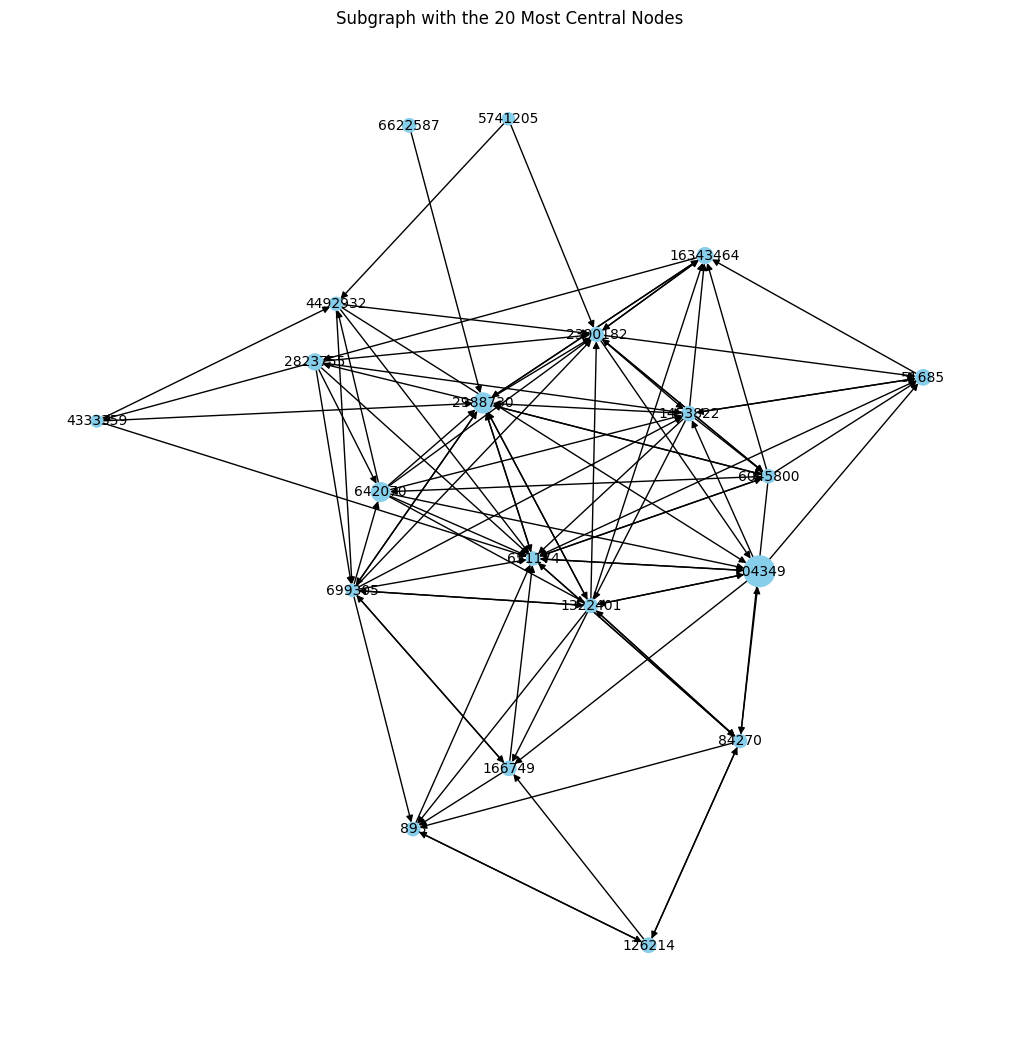

In [ ]:
# Visualize the 20 most central nodes (hubs) and their edges
top_central_nodes = central_nodes[:20]

# Create a subgraph with these nodes
subgraph = G.subgraph(top_central_nodes)

# Use a layout for positioning nodes on the plot
pos = nx.kamada_kawai_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=[centrality[n]*10000 for n in subgraph], edge_color='k', linewidths=1, font_size=10)

# Display the plot
plt.title("Subgraph with the 20 Most Central Nodes")
plt.show()
